# **1. 에일리언 VS 프레데터 데이터셋**
* [데이터셋](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images)
* https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
* 케글 로그인 -> 우측 상단의 계정을 클릭 -> Your Profile -> Setting -> Account -> API항목에 Create New API Token을 클릭 -> kaggle.json 파일이 다운로드 됨
* kaggle.json을 메모장으로 열기
    * {"username":"heeseonim","key":"7b42b2364adb43670fe8c3cf7022cae6"}


In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] ='heeseonim'
os.environ['KAGGLE_KEY']='7b42b2364adb43670fe8c3cf7022cae6'

In [3]:
# 다운
!kaggle datasets download -d pmigdal/alien-vs-predator-images

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
License(s): ODbL-1.0
 64% 9.00M/14.1M [00:00<00:00, 18.4MB/s]
100% 14.1M/14.1M [00:00<00:00, 28.5MB/s]


In [4]:
# 압축풀기 (같은 폴더에 있음 )
!unzip -q alien-vs-predator-images.zip

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models,transforms
from torch.utils.data import DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **2. 이미지 증강 기법(image Augmentation)**
* 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성하여 학습하는 기법
* 일반적으로 모델 성능이 좋아짐
* 오버피팅을 (over fitting) 방지
* https://pytorch.org/vision/master/transforms.html

In [7]:
data_transforms ={
    'train': transforms.Compose([
        transforms.Resize((224,224)), # 이미지를 224x224 크기로 조정
        # 각도, 찌그러뜨림,
        transforms.RandomAffine(0, shear=10 , scale =(0.8,12)),
        # 수평으로 뒤집기
        transforms.RandomHorizontalFlip(), # 좌우반전
        transforms.ToTensor(), # 이미지를 PyTorch 텐서로 변환
    ]),
    'validation':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [8]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [9]:
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

In [10]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size = 32,
        shuffle=False
    )
}

In [11]:
print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


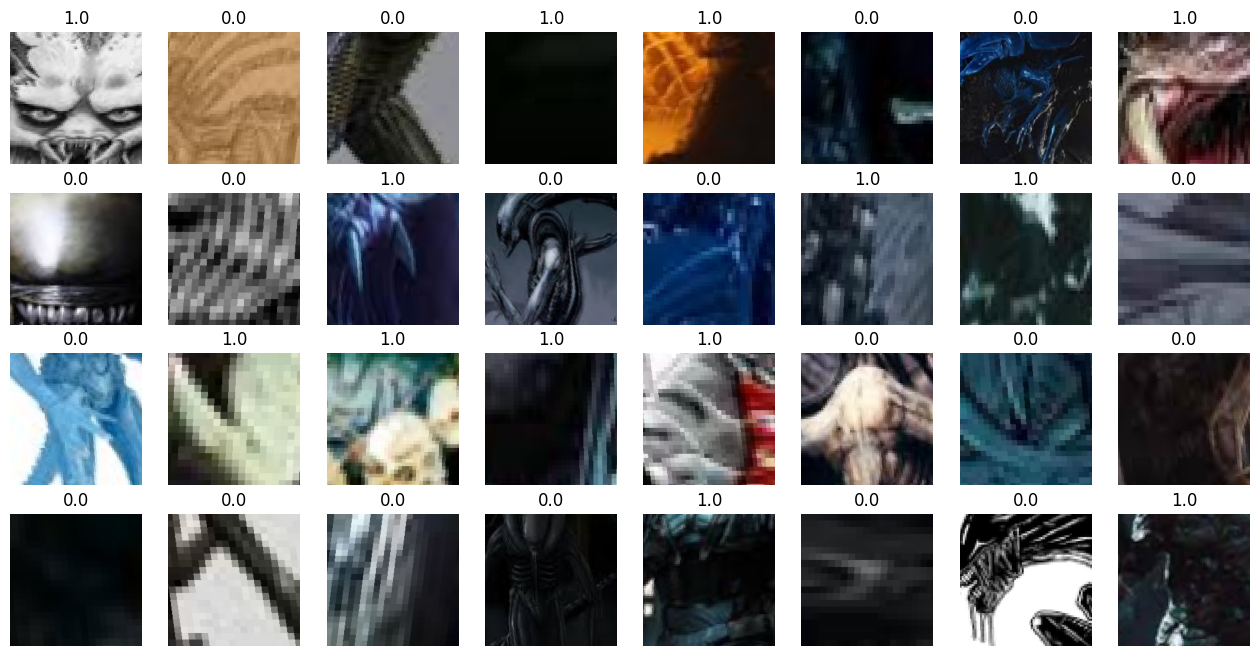

In [12]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4,8, figsize=(16,8))

for ax,img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

# **3. 전이 학습 (Transfer Learning)**
* 하나의 작업을 위해 훈련된 모델을 유사 작업 수행 모델의 시작점으로 활용할 수있는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는 것보다 전이 학습을 통해 업데이트하고 재학습하는 편이 더 빠르고 간편함
* 전이 학습은 여러 응용 분야(검출, 영상 인식, 음성 인식, 검색분야)에서 많이 사용됨
![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### 3-1. 전이 학습의 고려할 점
* 크기 : 모델 크기는 배포할 위치와 방법, 규모에 따라 달라짐
* 속도 및 정확도: 하트웨어, 배치 크기, 모델과 같은 요소를 고려

### 3-2. 사전 학습된 ResNet50 모델 사용하기
* [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)
* https://pytorch.org/vision/stable/models.html
![](https://i.stack.imgur.com/gI4zT.png)

### 3-3. ResNet50의 특징
* 네트워크가 이전 레이어의 출력을 다음 레이어로 직접 전달하는 '스킵 연결'을 통해 학습을 진행하는 방식
* 기울기 소실 문제를 해경하고 훨씬 더 깊은 네트워크를 효과적으로 학습시킬 수 있음
* 50개의 레이어로 구성되어 있으며 주로 Conv(컨볼루션) 레이어와 Batch Normalization, ReLU 활성화 함수, 출링 레이어 등으로 이루어져 있음
* 이미지 분류, 객체 탐지 등 다양한 컴퓨터 비전 작업에서 높은 성능을 보임

# **4. 이미지넷(ImageNet)**
* 이미지 데이터베이스
* 1000개의 클래스로 동물과 사물 이미지를 포함
![](https://i.imgur.com/5Rz5s8e.png)

In [13]:
model = models. resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **5. Freeze Layers**
* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을 하지 않도록 설정
* 출력 부분의 레이어(FC)를 다시 설정하여 분류에 맞게 변경

In [14]:
for param in model. parameters():
    param.requires_grad = False # 가져온 파라미터(W,b)를 업데이트하지 않음

In [15]:
model.fc = nn.Sequential(
    nn.Linear(2048,128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
). to (device)

print(model) # 해당모델을 보기 위  => 바뀝

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc  # 배치에 따른 계산

        avg_loss = sum_losses / len(dataloaders[phase])  # 에폭에 따른 계산
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10 Loss: 0.6817 Accuracy: 61.56%
validation: Epoch    1/10 Loss: 0.6058 Accuracy: 69.64%
train     : Epoch    2/10 Loss: 0.5763 Accuracy: 69.23%
validation: Epoch    2/10 Loss: 0.7274 Accuracy: 55.36%
train     : Epoch    3/10 Loss: 0.5270 Accuracy: 73.10%
validation: Epoch    3/10 Loss: 0.4729 Accuracy: 81.25%
train     : Epoch    4/10 Loss: 0.4875 Accuracy: 76.52%
validation: Epoch    4/10 Loss: 0.5028 Accuracy: 74.11%
train     : Epoch    5/10 Loss: 0.5524 Accuracy: 71.01%
validation: Epoch    5/10 Loss: 0.4490 Accuracy: 82.14%
train     : Epoch    6/10 Loss: 0.5029 Accuracy: 75.59%
validation: Epoch    6/10 Loss: 0.4735 Accuracy: 74.55%
train     : Epoch    7/10 Loss: 0.5149 Accuracy: 75.90%
validation: Epoch    7/10 Loss: 0.6333 Accuracy: 67.41%
train     : Epoch    8/10 Loss: 0.5105 Accuracy: 74.68%
validation: Epoch    8/10 Loss: 0.4052 Accuracy: 84.38%
train     : Epoch    9/10 Loss: 0.5062 Accuracy: 74.61%
validation: Epoch    9/10 Loss: 0.4035 Accuracy:

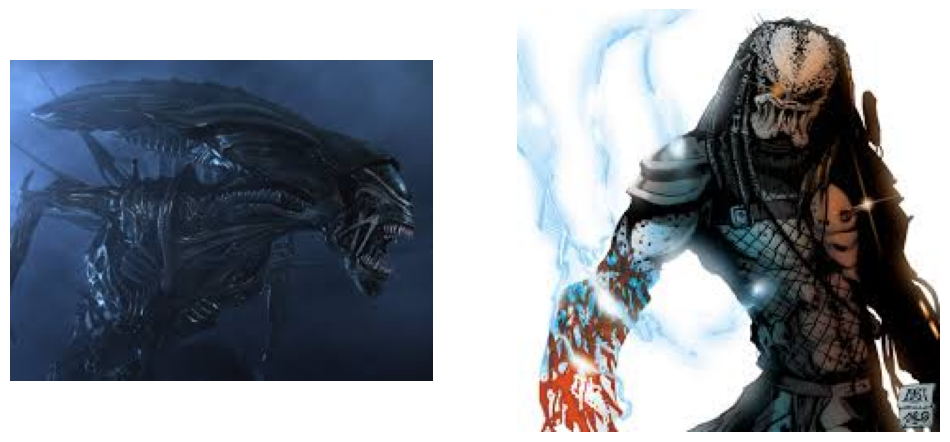

In [ ]:
# 테스트
from PIL import Image
img1 =Image.open('data/validation/alien/21.jpg')
img2 =Image.open('data/validation/predator/30.jpg')

fig,axes = plt.subplots(1,2,figsize =(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1]. axis('off')
plt.show()

In [ ]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
test_batch = torch.stack([img1_input,img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [ ]:
# 사이즈가 맞아야 들어감
y_pred = model(test_batch)
y_pred

tensor([[0.3907],
        [0.9459]], grad_fn=<SigmoidBackward0>)

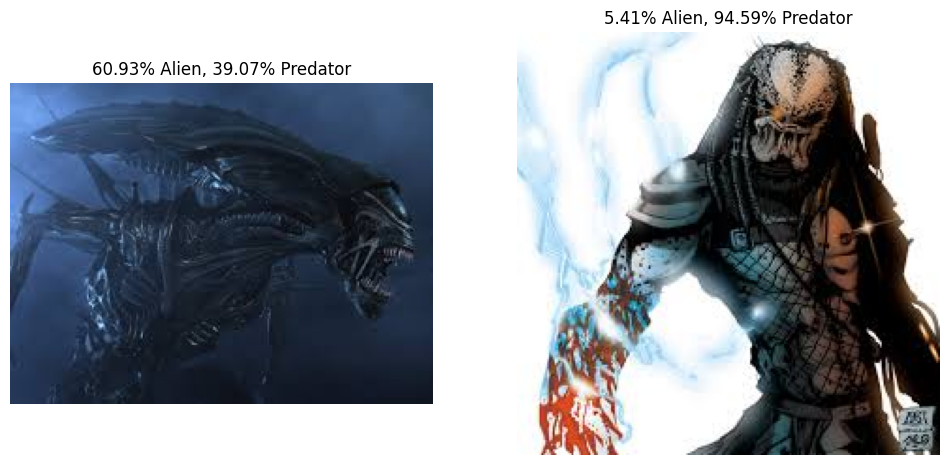

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% Alien, {y_pred[0, 0] * 100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')
# 다음 번호
axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% Alien, {y_pred[1, 0] * 100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()